In [44]:
import os, glob, shutil, re, string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import gensim

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.python.platform.build_info.build_info['cuda_version']

'64_101'

In [4]:
tf.python.platform.build_info.build_info['cudnn_version']

'64_7'

In [5]:
tf.__version__

'2.3.0'

## Description of the problem and data

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

### Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

### Columns

- id - a unique identifier for each tweet

- text - the text of the tweet

- location - the location the tweet was sent from (may be blank)

- keyword - a particular keyword from the tweet (may be blank)

- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [6]:
train = pd.read_csv('./nlp-getting-started/train.csv')
test = pd.read_csv('./nlp-getting-started/test.csv')
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
print('Train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('Test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

Train data has 7613 rows and 5 columns
Test data has 3263 rows and 4 columns


## Exploratory Data Analysis (EDA) 

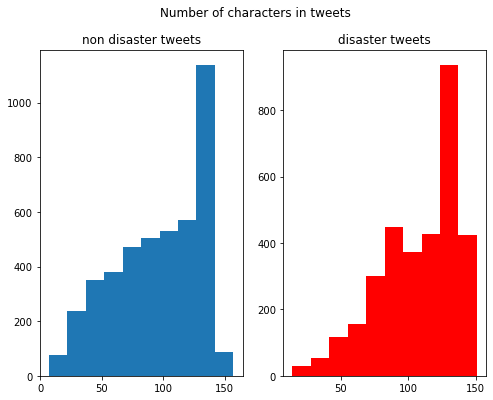

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,6))
train_len=train[train['target']==0]['text'].str.len()
ax1.hist(train_len)
ax1.set_title('non disaster tweets')
train_len = train[train['target']==1]['text'].str.len()
ax2.hist(train_len, color='r')
ax2.set_title('disaster tweets')
fig.suptitle('Number of characters in tweets')
plt.show()

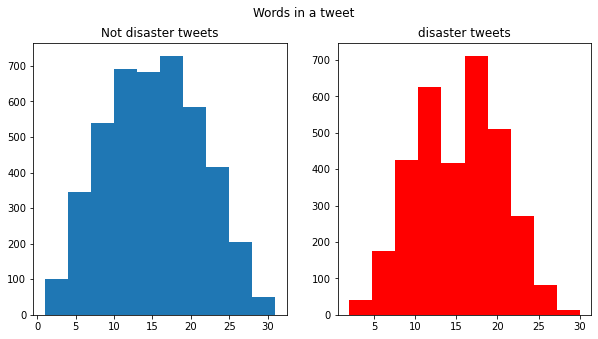

In [10]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len)
ax1.set_title('Not disaster tweets')
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len, color='r')
ax2.set_title('disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [11]:
def create_corpus(df, target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [12]:
corpus = create_corpus(train, 0)
stop=set(stopwords.words('english'))

In [13]:
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

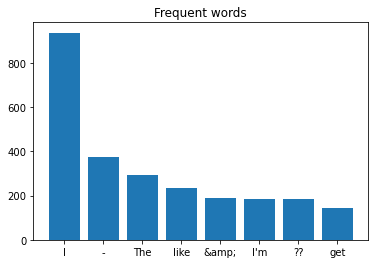

In [14]:
plt.title("Frequent words")
plt.bar(x,y);

### Data Cleaning

In [15]:
df=pd.concat([train, test])
df.shape

(10876, 5)

In [16]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [17]:
df['text'] = df['text'].apply(lambda x : remove_url(x))

In [18]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'', text)

In [19]:
df['text'] = df['text'].apply(lambda x : remove_html(x))

In [20]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [21]:
df['text'] = df['text'].apply(lambda x : remove_punct(x))

## Model Architecture

#### Global Vectors for Word Representation

In [22]:
def create_corpus_2(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [23]:
corpus = create_corpus_2(df)

100%|██████████████████████████████████████████████████████████████████████████| 10876/10876 [00:01<00:00, 9940.10it/s]


In [24]:
embedding_dict={}
with open('glove_twitter_27B/glove.twitter.27B.200d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

In [25]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()

In [26]:
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
train_pad = pad_sequences(sequences, maxlen=MAX_LEN,truncating='post', padding='post')

In [27]:
word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))

Number of unique words: 20342


In [28]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, 200))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue  
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|████████████████████████████████████████████████████████████████████████| 20342/20342 [00:00<00:00, 535916.16it/s]


#### LSTM model

In [50]:
model = Sequential()

embedding = Embedding(num_words, 200, 
                      embeddings_initializer=Constant(embedding_matrix), 
                      input_length=MAX_LEN,
                      trainable=False
                     )

model.add(embedding)
model.add(SpatialDropout1D(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0)))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 200)           4068600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 200)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 128)           135680    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,245,561
Trainable params: 176,961
Non-trainable params: 4,068,600
_________________________________________________________________


In [52]:
train_data = train_pad[:train.shape[0]]
test_data = train_pad[train.shape[0]:]

In [53]:
train_data.shape

(7613, 50)

In [54]:
test_data.shape

(3263, 50)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train['target'].values, test_size=0.1)

In [56]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test,y_test),
                    batch_size=8, 
                    epochs=30)

Epoch 1/30
857/857 [==============================] - 8s 10ms/step - loss: 0.4728 - accuracy: 0.7822 - val_loss: 0.4461 - val_accuracy: 0.7992
Epoch 2/30
857/857 [==============================] - 8s 9ms/step - loss: 0.4228 - accuracy: 0.8111 - val_loss: 0.4605 - val_accuracy: 0.8084
Epoch 3/30
857/857 [==============================] - 8s 9ms/step - loss: 0.3998 - accuracy: 0.8278 - val_loss: 0.4799 - val_accuracy: 0.8110
Epoch 4/30
857/857 [==============================] - 8s 9ms/step - loss: 0.3715 - accuracy: 0.8443 - val_loss: 0.4574 - val_accuracy: 0.8097
Epoch 5/30
857/857 [==============================] - 8s 9ms/step - loss: 0.3534 - accuracy: 0.8497 - val_loss: 0.4786 - val_accuracy: 0.8005
Epoch 6/30
857/857 [==============================] - 8s 9ms/step - loss: 0.3338 - accuracy: 0.8622 - val_loss: 0.4767 - val_accuracy: 0.8045
Epoch 7/30
857/857 [==============================] - 7s 9ms/step - loss: 0.3061 - accuracy: 0.8770 - val_loss: 0.4889 - val_accuracy: 0.8058
Epoch

## Results and Analysis 

In [57]:
def plots(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

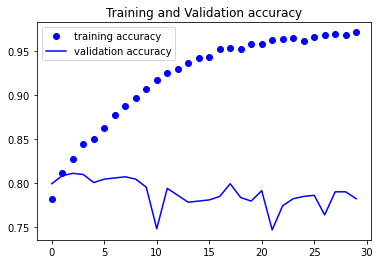

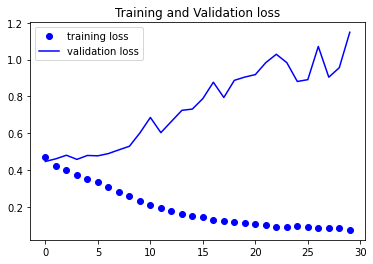

In [58]:
plots(history)

In [59]:
sample_sub = pd.read_csv('./nlp-getting-started/sample_submission.csv')

In [60]:
y_pre = model.predict(test_data)
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(), 'target':y_pre})
sub.to_csv('submission.csv', index=False)

<img src="files/my_result_1.png">

## Conclusion

My final score was 0.79. As we can observe from the loss graph, overfitting happened here. So it is considered that using more robust model or adding regulations could improve the result. 